In [1]:
import math
from datetime import timedelta

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tsfresh as ts
from edgeml import edgeml

## Load datasets

In [2]:
URL = "https://app.edge-ml.org"
KEY = "dSCctVkGbmT/tMoPX4u6/2lzjQ82zWLweyUpBP7C/oYeXtNGi9iyiwMXr+JTbBzh+Yk1Oh/kJZiiGM/y6HLj2Q=="
project = edgeml.getProject(URL, KEY)

fetching project...


In [3]:
data_list = []
for dataset in project["datasets"]:
    label = dataset["labels"][0][0]["name"]
    subject = dataset["metaData"]["participantId"]
    data_obj = {}
    for sensor in dataset["sensors"]:
        sensor_name = sensor["name"]
        for datapoint in sensor["data"]:
            if datapoint["timestamp"] not in data_obj:
                data_obj[datapoint["timestamp"]] = {}
            if "label" not in data_obj[datapoint["timestamp"]]:
                data_obj[datapoint["timestamp"]]["label"] = label
            if "subject" not in data_obj[datapoint["timestamp"]]:
                data_obj[datapoint["timestamp"]]["subject"] = subject
            data_obj[datapoint["timestamp"]][sensor_name] = datapoint["datapoint"]
    df = pd.DataFrame.from_dict(data_obj, orient="index")
    df.reset_index(inplace=True)
    df.rename(columns={"index": "timestamp"}, inplace=True)
    df["timestamp"] = pd.to_datetime(df["timestamp"] / 1000, unit="s")
    data_list.append(df)

In [4]:
data_list[0].head()

,timestamp,label,subject,x0,y0,z0,x,y,z,alpha,beta,gamma
0,2022-08-11 10:37:02.815000064,reading,1086e,0.00,0.01,-0.02,-0.23,-6.99,-6.89,-3.19,0.38,-1.16
1,2022-08-11 10:37:02.831000064,reading,1086e,0.00,0.07,0.01,-0.22,-6.92,-6.87,-4.89,-1.07,-0.50
2,2022-08-11 10:37:02.846999808,reading,1086e,0.00,0.05,-0.12,-0.23,-6.92,-7.01,-5.93,-1.34,-0.31
3,2022-08-11 10:37:02.864000000,reading,1086e,-0.01,0.01,-0.18,-0.24,-6.96,-7.08,-5.51,0.06,-0.37
4,2022-08-11 10:37:02.880999936,reading,1086e,-0.07,-0.02,-0.20,-0.30,-6.98,-7.11,-4.69,0.42,-0.97


## Visualize dataset

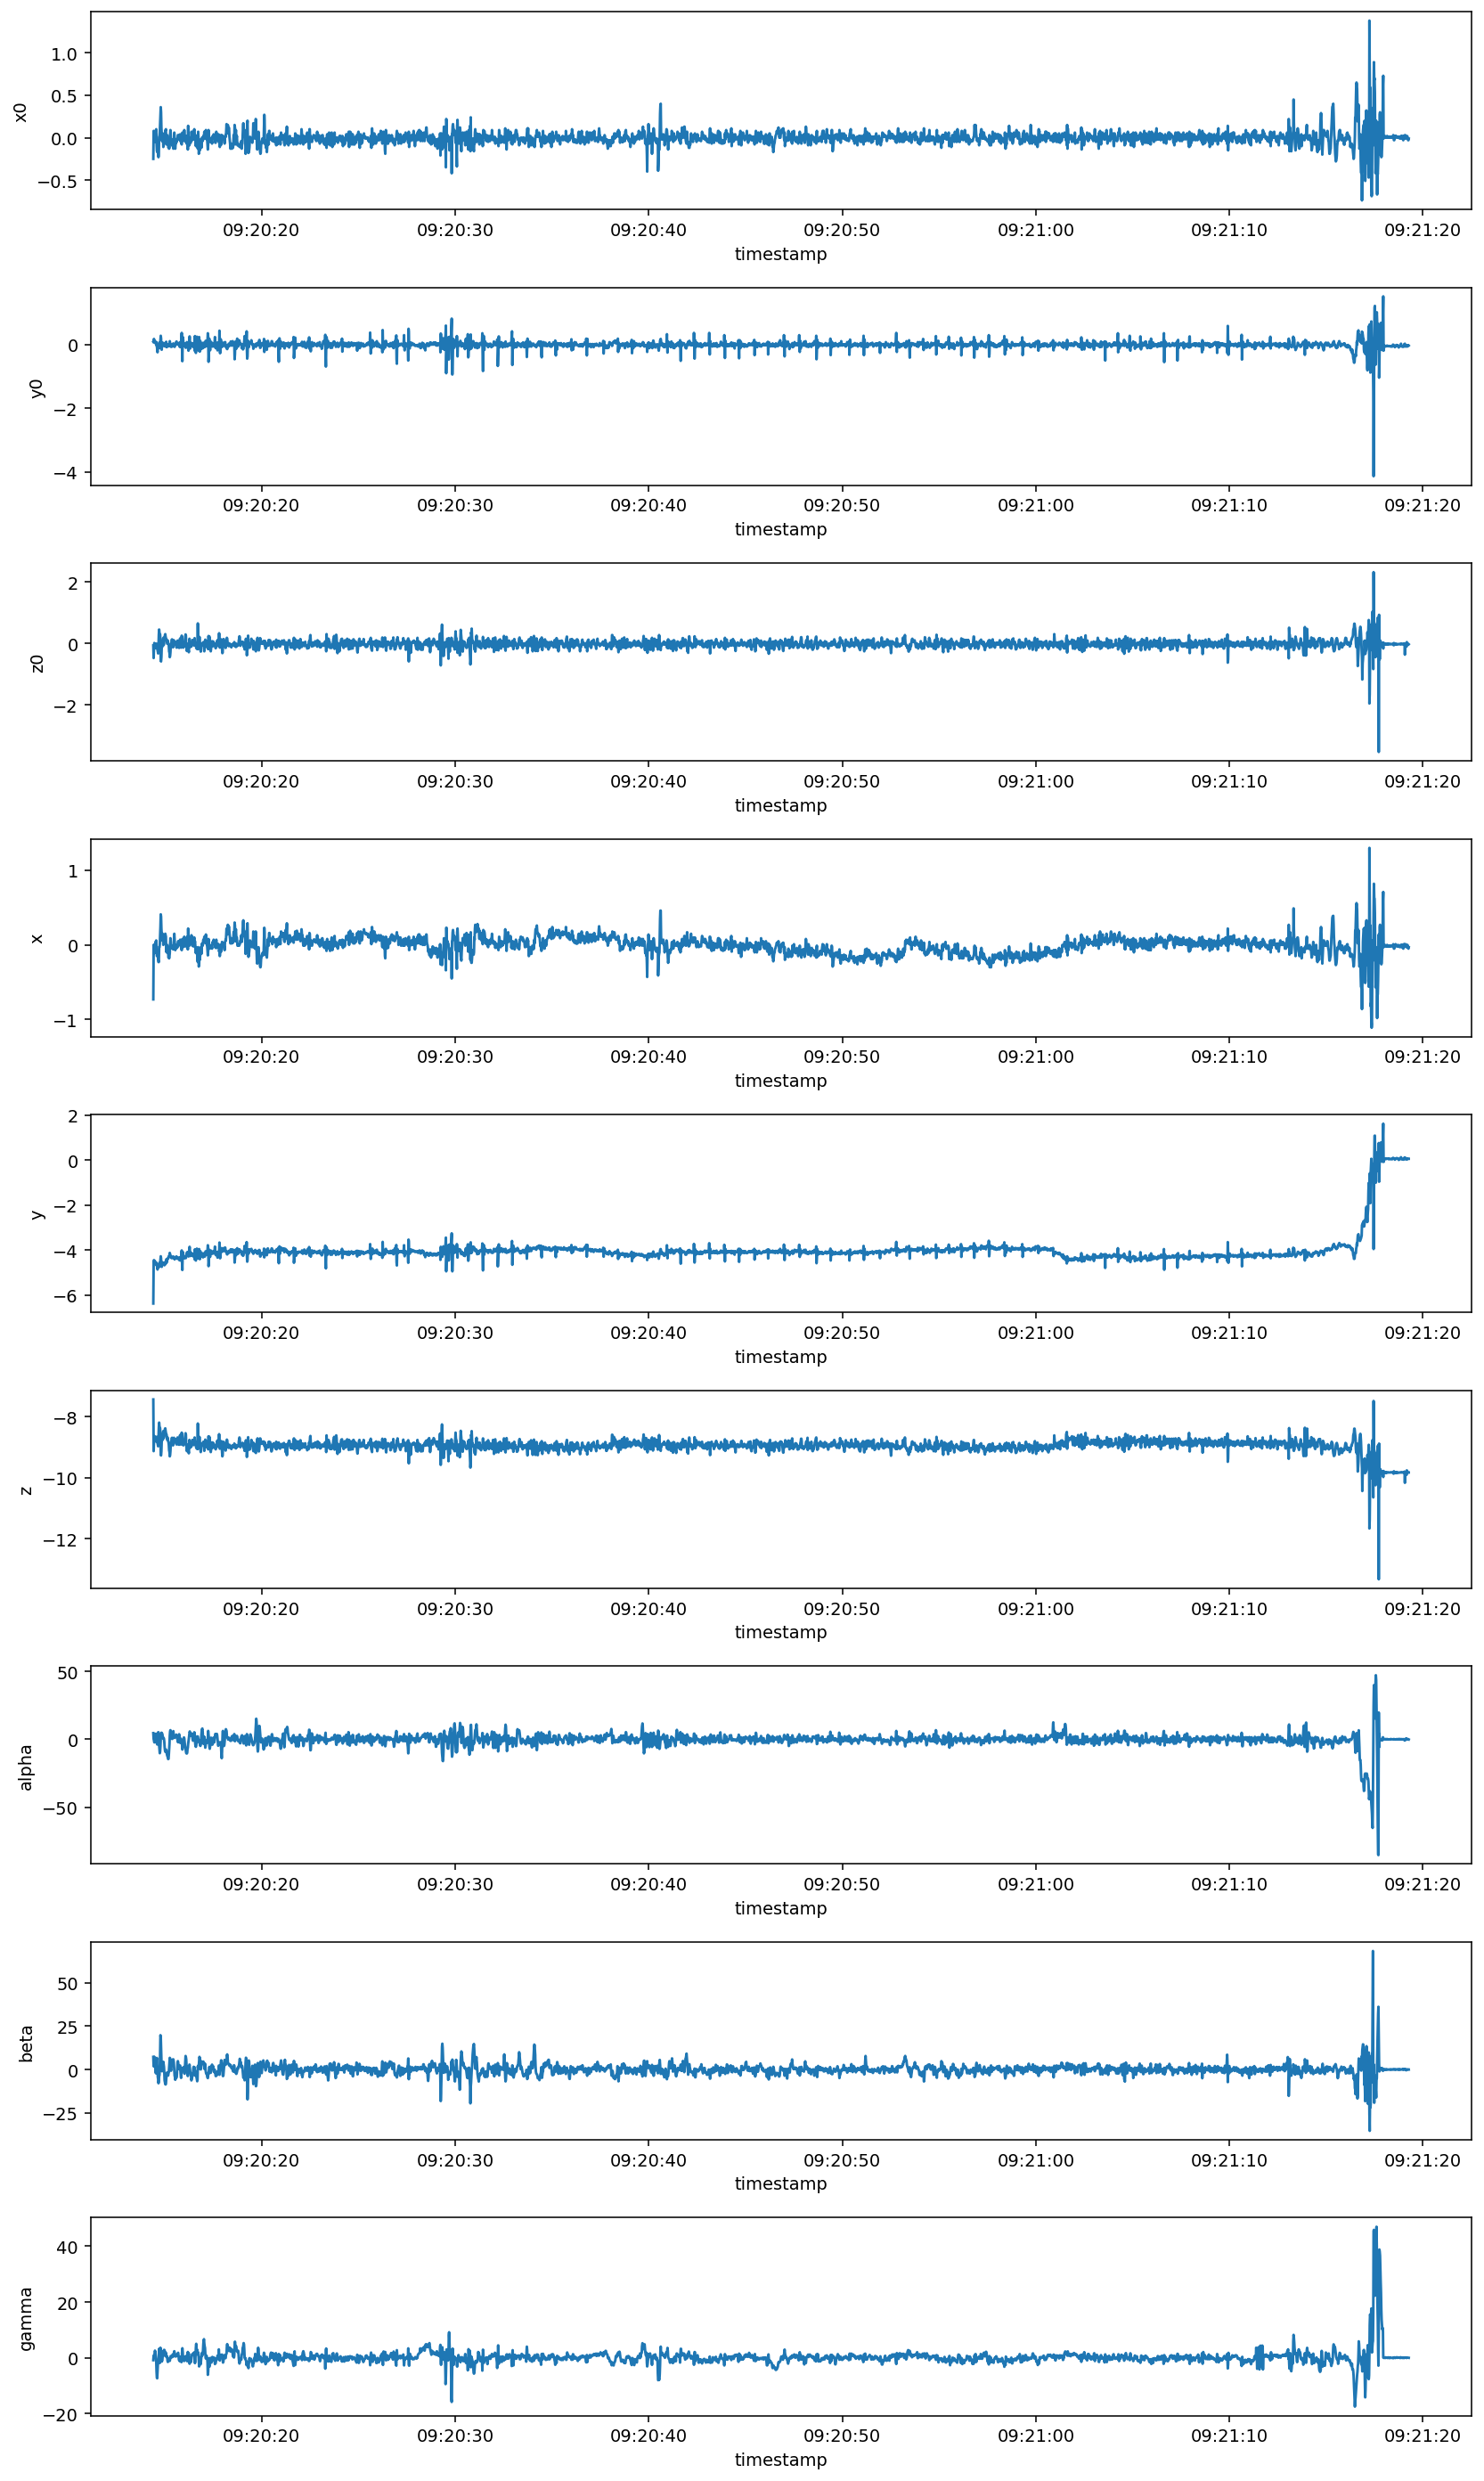

In [5]:
def plot_dataset(dataset):
    columns = dataset.columns.drop(["timestamp", "label", "subject"])
    fig, axes = plt.subplots(nrows=len(columns), figsize=(12, 20), dpi=140)
    for i, column in enumerate(columns):
        sns.lineplot(x="timestamp", y=column, data=dataset, ax=axes[i])
    fig.tight_layout()
    plt.show()


plot_dataset(data_list[3])

## Clean datasets
Delete the first and last 10 seconds of the time-series to remove the transient effect

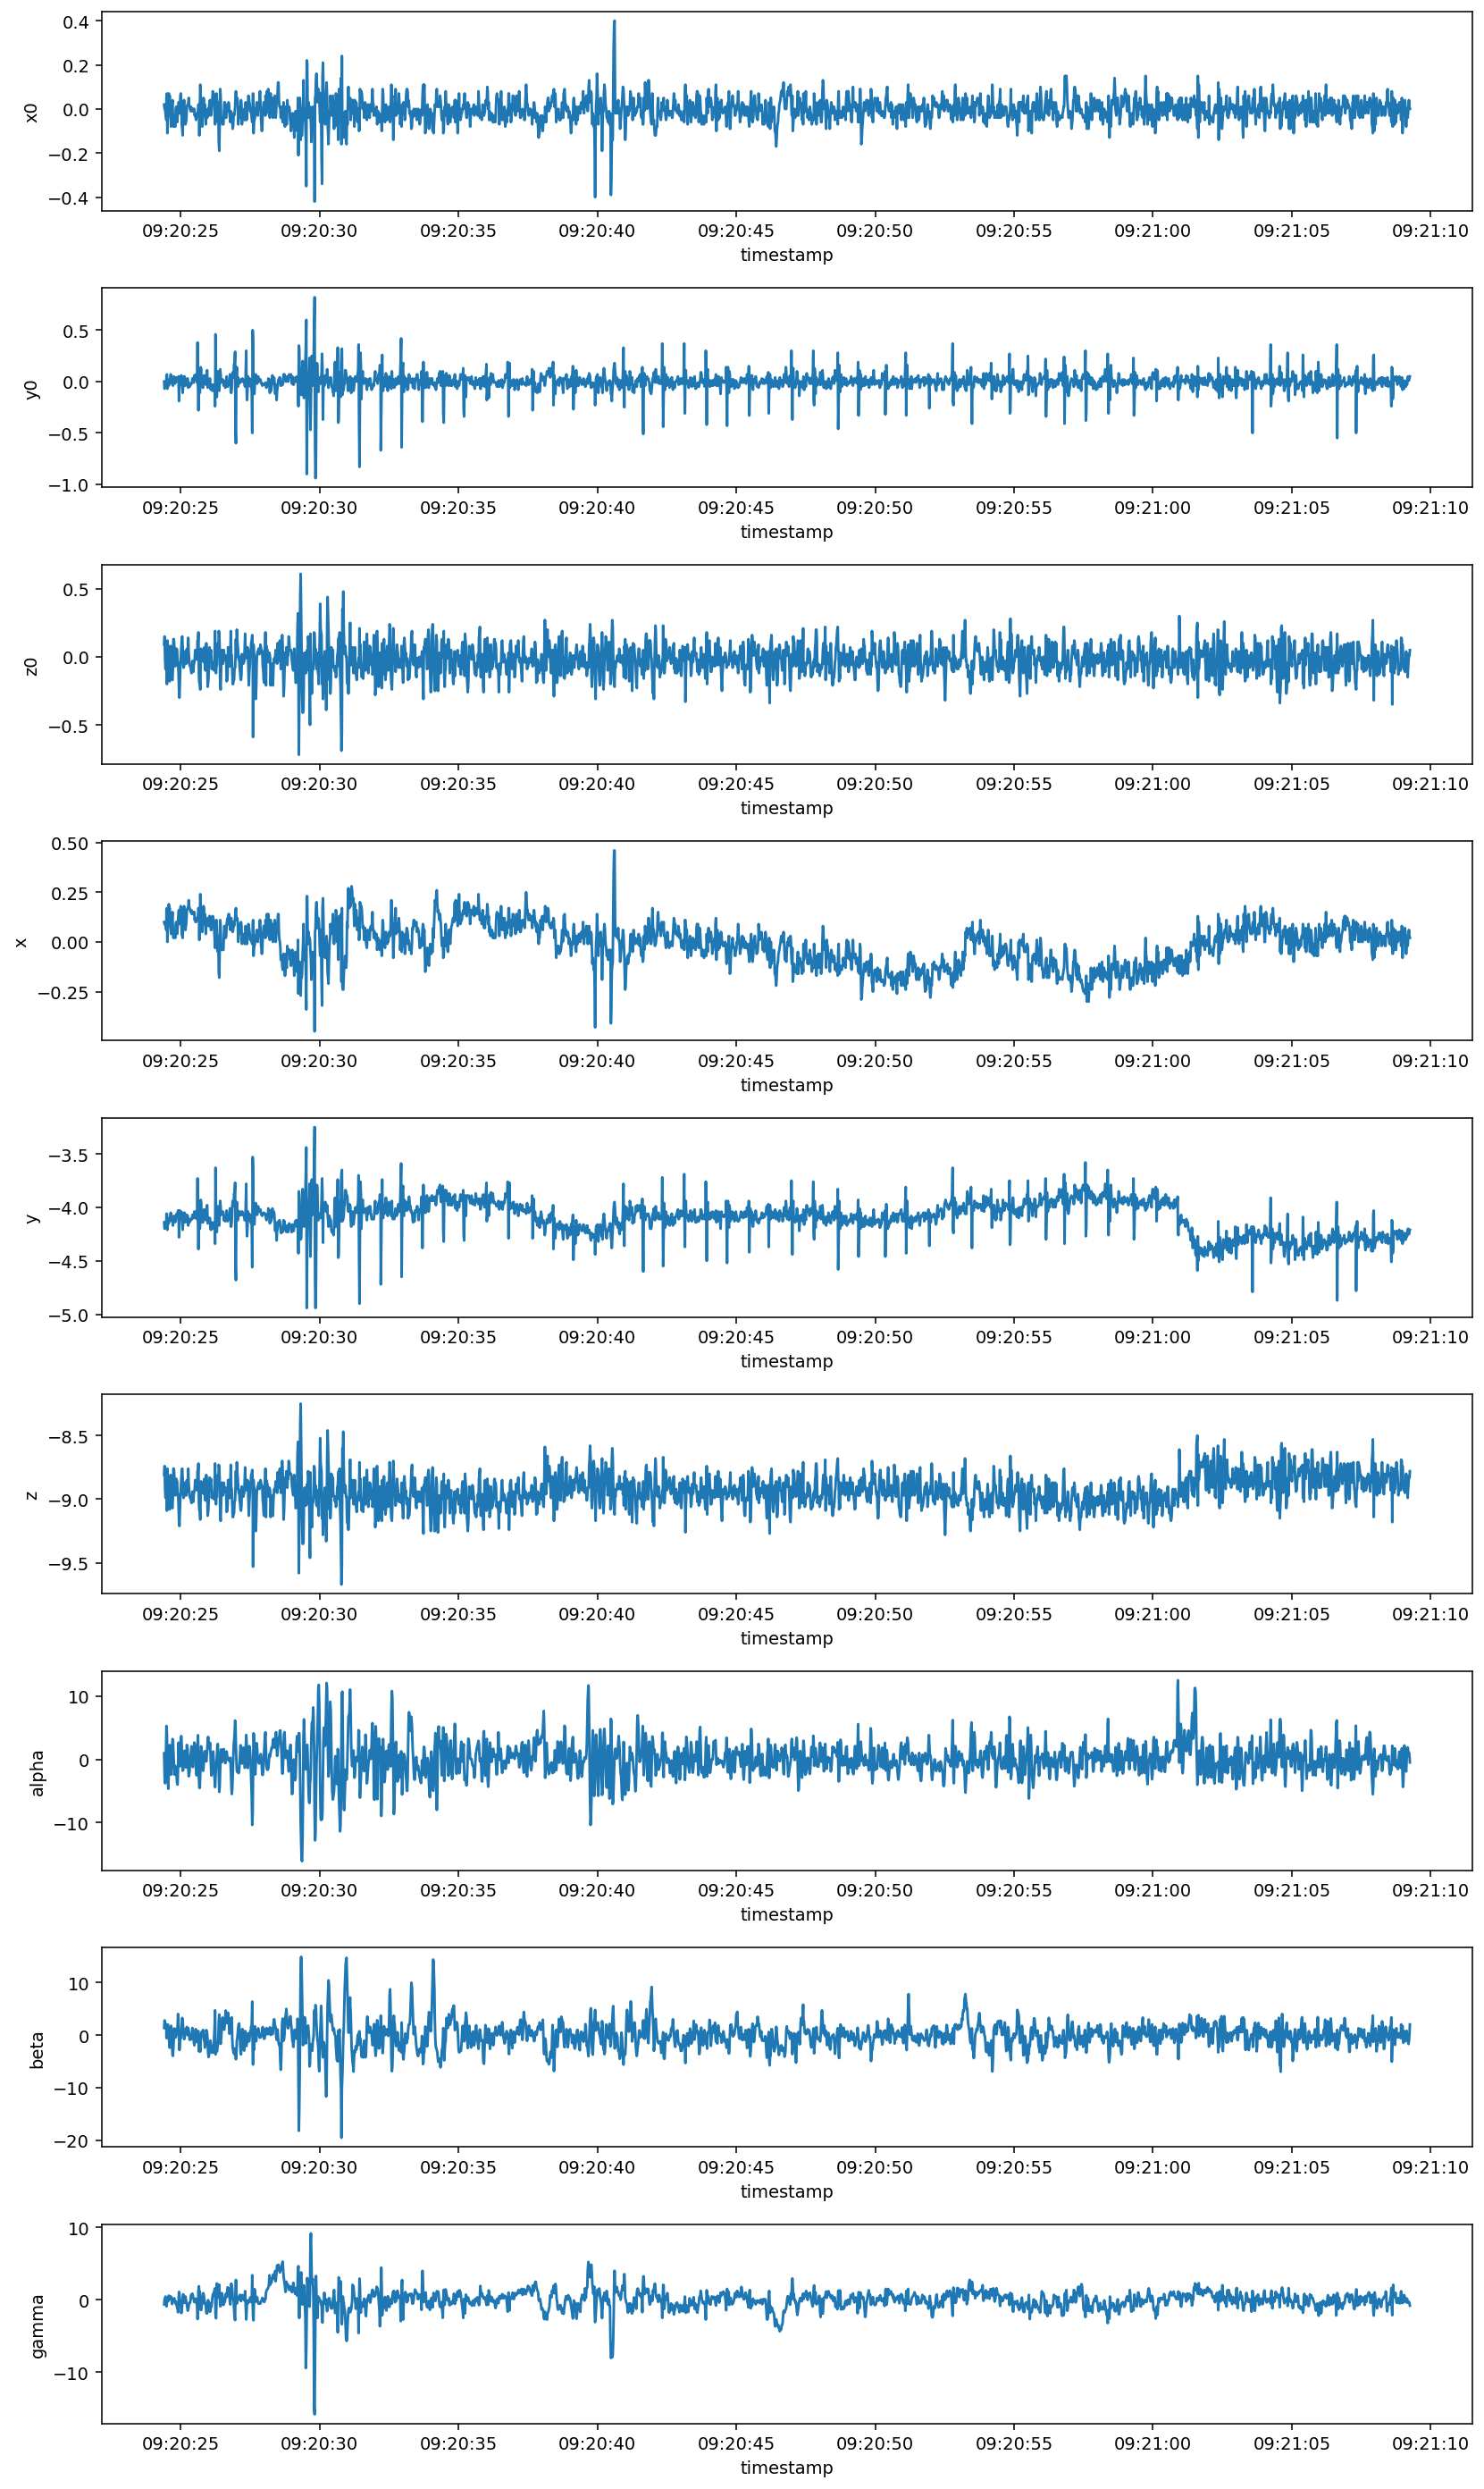

In [6]:
for i, df in enumerate(data_list):
    start = df["timestamp"].to_list()[0] + timedelta(seconds=10)
    end = df["timestamp"].to_list()[-1] - timedelta(seconds=10)
    df = df[(df["timestamp"] > start) & (df["timestamp"] < end)]
    data_list[i] = df.copy()

plot_dataset(data_list[3])

## Feature extraction

In [7]:
data_full = pd.DataFrame()
for data in data_list:
    data["window"] = data.apply(lambda x: x["timestamp"].round(freq="1s"), axis=1)
    label = data["label"].iloc[0]
    subject = data["subject"].iloc[0]
    data.drop(columns=["timestamp", "label", "subject"], inplace=True)
    data = ts.extract_features(
        data, column_id="window", default_fc_parameters=ts.feature_extraction.MinimalFCParameters()
    )
    data.reset_index(inplace=True)
    data.rename(columns={"index": "timestamp"}, inplace=True)
    data["label"] = label
    data["subject"] = subject
    data_full = pd.concat([data_full, data])

data_full.to_csv(f"../data/data.csv", index=False)

Feature Extraction: 100%|██████████████████████| 29/29 [00:00<00:00, 894.68it/s]


In [8]:
data_full.head()

,timestamp,x0__sum_values,x0__median,x0__mean,x0__length,x0__standard_deviation,x0__variance,x0__root_mean_square,x0__maximum,x0__minimum,...,gamma__median,gamma__mean,gamma__length,gamma__standard_deviation,gamma__variance,gamma__root_mean_square,gamma__maximum,gamma__minimum,label,subject
0,2022-08-11 10:37:13,0.07,0.010,0.001707,41.0,0.047210,0.002229,0.047241,0.10,-0.10,...,-0.050,0.152683,41.0,0.838483,0.703054,0.852271,2.22,-1.33,reading,1086e
1,2022-08-11 10:37:14,0.77,0.010,0.012833,60.0,0.040665,0.001654,0.042642,0.10,-0.06,...,0.450,0.403167,60.0,0.921075,0.848378,1.005446,2.49,-1.19,reading,1086e
2,2022-08-11 10:37:15,0.63,0.015,0.010500,60.0,0.039683,0.001575,0.041049,0.11,-0.07,...,-0.020,0.014667,60.0,0.793319,0.629355,0.793454,1.29,-2.16,reading,1086e
3,2022-08-11 10:37:16,0.57,0.010,0.009500,60.0,0.030953,0.000958,0.032378,0.08,-0.06,...,0.035,0.006500,60.0,0.748418,0.560129,0.748446,2.51,-2.13,reading,1086e
4,2022-08-11 10:37:17,0.60,0.020,0.010000,60.0,0.041593,0.001730,0.042778,0.08,-0.10,...,-0.015,-0.010667,60.0,0.724681,0.525163,0.724760,1.63,-1.79,reading,1086e


## Visualize features space

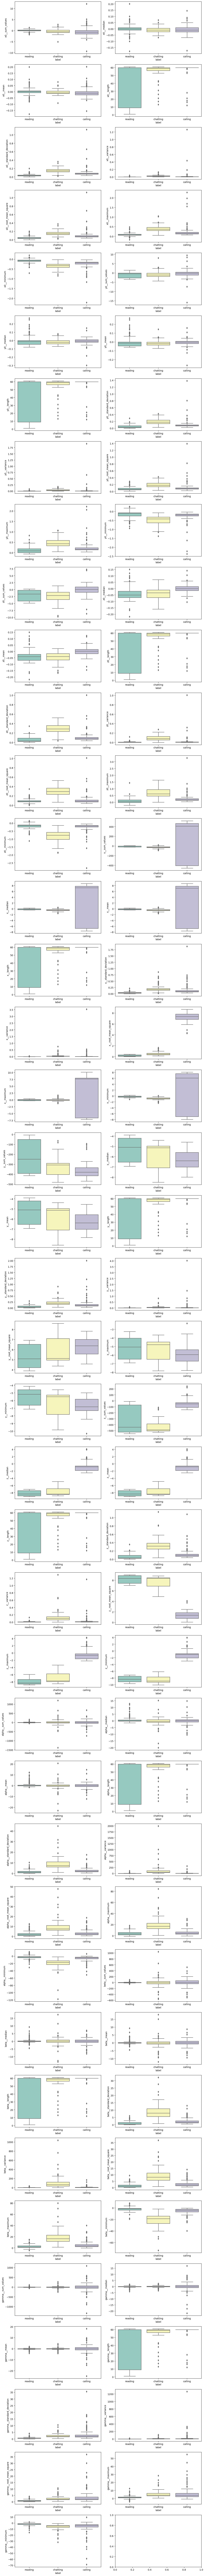

In [9]:
columns = data_full.columns.drop(["timestamp", "label", "subject"])

fig, axes = plt.subplots(nrows=math.ceil(len(columns) / 2), ncols=2, figsize=(12, 150), dpi=140)

for i, column in enumerate(columns):
    sns.boxplot(x="label", y=column, data=data_full, ax=axes[i // 2, i % 2], palette="Set3")

fig.tight_layout()
plt.show()